In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import jaydebeapi as jay

In [14]:
datafile = "/Users/yanchunyang/Documents/datafiles/ltv/"

In [15]:
predict_file = "dftotal.csv"
actual_file = "testdata.csv"

In [4]:
def read_from_snowflake(sql_str):
    with open('/Users/yanchunyang/pwd/snowflake.passphrase', 'r') as f:
        passphrase = f.read().strip()
    username = "yanchun.yang@dave.com"
    password = "abc"
    jdbcpath = "/Users/yanchunyang/lib/jdbc/snowflake-jdbc-3.13.8.jar"
    jdbc_driver_name = "net.snowflake.client.jdbc.SnowflakeDriver"
    hostname= "qc63563.snowflakecomputing.com"
    role = "FUNC_ACCOUNTING_USER"
    warehouse = "ACCOUNTING_WH"
    keyfile = "/Users/yanchunyang/.ssh/snowflake.p8"

    conn_string = f'jdbc:snowflake://qc63563.snowflakecomputing.com?role={role}&warehouse={warehouse}&private_key_file={keyfile}&private_key_file_pwd={passphrase}'

    conn = jay.connect(jdbc_driver_name, conn_string, {'user': username , 'password': password }, jars=jdbcpath)

#  Currently python can't interpret correctly the result returned from JDBC to connect Snowflake so we have to switch back to JSON rather than ARROW format
# It can be done at session level
    session_set = "ALTER SESSION SET JDBC_QUERY_RESULT_FORMAT='JSON'"
    curs = conn.cursor()
    curs.execute(session_set)

    curs.execute(sql_str)
    result = curs.fetchall()
    return result

In [7]:
sql_all = "SELECT * FROM  ACCOUNTING.DBT_LOCAL.LTV_USER_2022"

In [8]:
df_all = read_from_snowflake(sql_all)

In [10]:
columns = ['userid', 'startdate', 'platform', 'attribution', 'network']

In [12]:
df = pd.DataFrame(df_all, columns=columns)

In [13]:
df.shape

(3005400, 5)

In [44]:
predict_df = pd.read_csv(datafile + predict_file, header=0)
actual_df = pd.read_csv(datafile + actual_file)
predict_update = predict_df.loc[:, ['userid', 'pred_num', 't_value', 'frequency', 'prob_alive']]
actual_update = actual_df.loc[:, ['userid', 'trans_num', 'real_revenue']]

In [45]:
combine_1 = pd.merge(df, predict_df, on=['userid'], how='left')
combine_2 = pd.merge(combine_1, actual_df, on=['userid'], how='left')

In [46]:
combine_2 = combine_2.fillna(0)

In [47]:
combine_2 = combine_2.drop(['Unnamed: 0.1', 'Unnamed: 0_x','Unnamed: 0_y'], axis=1)

In [27]:
combine_2.columns

Index(['userid', 'startdate', 'platform', 'attribution', 'network',
       'first_trans', 'frequency', 'T', 'recency', 'monetary', 'pred_num',
       'monetary_update', 'prob_alive', 'expected_monetary', 't_value',
       'trans_num', 'real_revenue'],
      dtype='object')

In [35]:
combine_2.head(2)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,prob_alive,expected_monetary,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label
0,11670673,2021-10-06,ios,ORGANIC,Organic,2021-10-29,2.0,95.0,24.0,4.156667,...,0.421666,5.596436,6.929668,0.0,0.0,2021-10-06,2021-10-01,1,0,1
1,11568202,2021-09-23,ios,PAID,Snapchat,0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,2021-09-23,2021-09-01,0,0,0


In [48]:
combine_2['start_date'] = pd.to_datetime(combine_2['startdate'])

In [49]:
combine_2['start_month'] = combine_2['start_date'].apply(lambda x: x.strftime('%Y-%m-01'))

In [50]:
combine_2['predict_label'] = combine_2['first_trans'].apply(lambda x: 1 if x !=0 else 0)
combine_2['actual_label'] = combine_2['trans_num'].apply(lambda x: 1 if x != 0 else 0)

In [51]:
combine_2['tmp_label'] = combine_2['predict_label'] + combine_2['actual_label']
combine_2['active_label'] = combine_2['tmp_label'].apply(lambda x: 1 if x !=0 else 0)
combine_2 = combine_2.drop(['tmp_label'], axis=1)

In [52]:
pv_churn = combine_2.groupby(['start_month']).agg({'userid': 'count', 'active_label': 'sum'}).reset_index()

In [53]:
pv_churn['rate'] = pv_churn['active_label'] / pv_churn['userid']

In [54]:
combine_2.loc[combine_2['start_month']=='2022-01-01',:].head(4)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,prob_alive,expected_monetary,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label
26,12427970,2022-01-15,ios,PAID,Apple Search Ads,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,0.0,0.00,2022-01-15,2022-01-01,0,0,0
42,12347691,2022-01-04,android,PAID,bytedanceglobal_int,2022-01-04,0.0,28.0,0.0,4.99,...,1.0,4.99,11.08115,1.0,5.99,2022-01-04,2022-01-01,1,1,1
67,12554425,2022-01-31,android,PAID,Adwords,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,0.0,0.00,2022-01-31,2022-01-01,0,0,0
80,12536510,2022-01-29,ios,PAID,Apple Search Ads,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,4.0,23.46,2022-01-29,2022-01-01,0,1,1


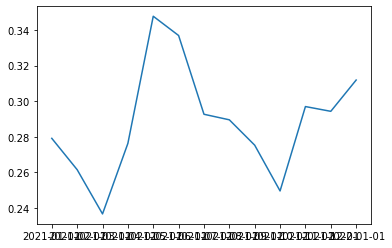

In [55]:
plt.plot(pv_churn['start_month'], pv_churn['rate'])

In [56]:
dftmp = combine_2.loc[combine_2['predict_label'] == 1, ]
predict_bymonth = dftmp.groupby(['start_month']).agg({'t_value': np.mean, 'real_revenue': np.mean}).reset_index()

<AxesSubplot:>

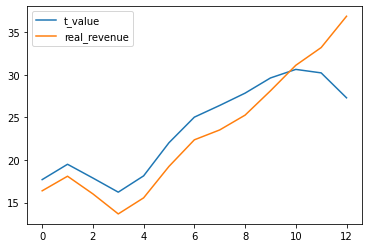

In [57]:
predict_bymonth.plot()

In [61]:
dftmp['actual_retention'] = dftmp['real_revenue'].apply(lambda x: 1 if int(x) > 0 else 0)

/var/folders/d1/rw6rwxz927g254dvggnj0jpr0000gn/T/ipykernel_88305/2688319310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftmp['actual_retention'] = dftmp['real_revenue'].apply(lambda x: 1 if int(x) > 0 else 0)


In [62]:
predict_retention = dftmp.groupby(['start_month']).agg({'prob_alive':np.mean, 'actual_retention':np.mean})

<AxesSubplot:xlabel='start_month'>

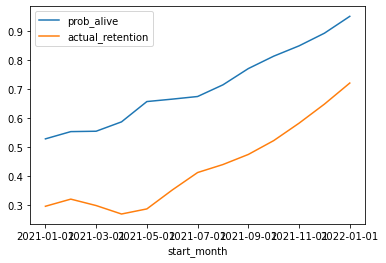

In [63]:
predict_retention.plot()

In [64]:
combine_2.columns

Index(['userid', 'startdate', 'platform', 'attribution', 'network',
       'first_trans', 'frequency', 'T', 'recency', 'monetary', 'pred_num',
       'monetary_update', 'prob_alive', 'expected_monetary', 't_value',
       'trans_num', 'real_revenue', 'start_date', 'start_month',
       'predict_label', 'actual_label', 'active_label'],
      dtype='object')

In [65]:
dftmp.head(4)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label,actualchurn,actual_retention
0,11670673,2021-10-06,ios,ORGANIC,Organic,2021-10-29,2.0,95.0,24.0,4.156667,...,6.861211,0.0,0.00,2021-10-06,2021-10-01,1,0,1,0,0
3,11231405,2021-08-10,android,PAID,Adwords,2021-08-10,21.0,175.0,174.0,4.628636,...,91.218055,4.0,23.96,2021-08-10,2021-08-01,1,1,1,1,1
6,10972388,2021-07-07,ios,PAID,Apple Search Ads,2021-12-08,2.0,55.0,25.0,4.990000,...,23.842932,0.0,0.00,2021-07-07,2021-07-01,1,0,1,0,0
7,11355457,2021-08-26,ios,ORGANIC,Organic,2021-10-06,1.0,118.0,93.0,3.990000,...,11.093794,0.0,0.00,2021-08-26,2021-08-01,1,0,1,0,0


In [66]:
predict_bymonthplatform = dftmp.groupby(['start_month', 'platform']).agg({'t_value': np.mean, 'real_revenue': np.mean}).reset_index()

In [69]:
predict_bymonthplatform_ios = predict_bymonthplatform.loc[predict_bymonthplatform['platform']=='ios',:]

<AxesSubplot:>

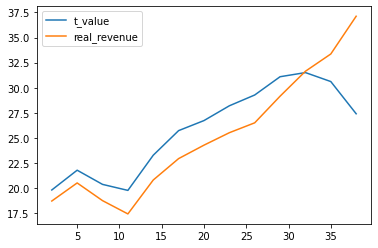

In [70]:
predict_bymonthplatform_ios.plot()

In [71]:
predict_bymonthplatform_android = predict_bymonthplatform.loc[predict_bymonthplatform['platform']=='android',:]

<AxesSubplot:>

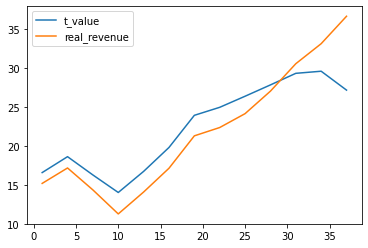

In [72]:
predict_bymonthplatform_android.plot()

In [73]:
predict_bymonthplatform.head(5)

,start_month,platform,t_value,real_revenue
0,2021-01-01,0,7.850212,5.248767
1,2021-01-01,android,16.564829,15.176519
2,2021-01-01,ios,19.831606,18.732509
3,2021-02-01,0,8.116141,6.001573
4,2021-02-01,android,18.605088,17.157173


In [82]:
predict_pivot = predict_bymonthplatform.loc[predict_bymonthplatform['platform'].isin(['ios', 'android']),['t_value', 'start_month', 'platform']]

In [83]:
predict_df = pd.pivot_table(predict_pivot, index=['start_month'], columns='platform', values='t_value', aggfunc='sum')

In [84]:
predict_df

platform,android,ios
start_month,,
2021-01-01,16.564829,19.831606
2021-02-01,18.605088,21.798804
2021-03-01,16.259466,20.387722
2021-04-01,14.012981,19.790171
2021-05-01,16.718970,23.290099
2021-06-01,19.785947,25.737430
2021-07-01,23.907261,26.736917
2021-08-01,24.933536,28.207124
2021-09-01,26.354483,29.281975


<AxesSubplot:xlabel='start_month'>

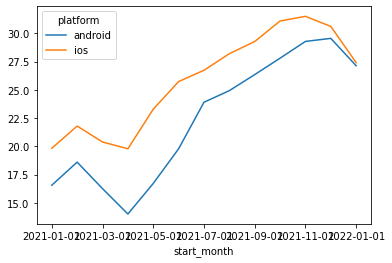

In [85]:
predict_df.plot()